In [1]:
!pip install openpyxl


In [2]:
!pip install scikit-learn


In [3]:
import pandas as pd

# Load the Excel file
df = pd.read_excel(r'OnlineRetail.xlsx')

# Save it as CSV
df.to_csv(r'OnlineRetail.csv', index=False)


In [4]:
df = pd.read_csv(r'OnlineRetail.csv', encoding='ISO-8859-1')
df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [5]:
# Drop missing CustomerID
df.dropna(subset=['CustomerID'], inplace=True)

# Remove cancelled transactions
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]


In [6]:
df['TotalAmount'] = df['Quantity'] * df['UnitPrice']


In [7]:
# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Define reference date for recency calculation (usually 1 day after last invoice)
reference_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

# Group by CustomerID
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',  # Frequency
    'TotalAmount': 'sum'     # Monetary
})

# Rename columns
rfm.columns = ['Recency', 'Frequency', 'Monetary']


In [8]:
# One-hot encode Country
country_dummies = pd.get_dummies(df[['CustomerID', 'Country']], columns=['Country'])

# Aggregate by CustomerID
country_encoded = country_dummies.groupby('CustomerID').sum().drop(columns='CustomerID', errors='ignore')

# Merge with RFM
rfm_final = rfm.merge(country_encoded, left_index=True, right_index=True)


In [9]:
# Final cleaned and feature-engineered DataFrame
rfm_final.head()


,Recency,Frequency,Monetary,Country_Australia,Country_Austria,Country_Bahrain,Country_Belgium,Country_Brazil,Country_Canada,Country_Channel Islands,...,Country_RSA,Country_Saudi Arabia,Country_Singapore,Country_Spain,Country_Sweden,Country_Switzerland,Country_USA,Country_United Arab Emirates,Country_United Kingdom,Country_Unspecified
CustomerID,,,,,,,,,,,,,,,,,,,,,
12346.0,326,1,77183.60,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
12347.0,2,7,4310.00,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12348.0,75,4,1797.24,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12349.0,19,1,1757.55,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12350.0,310,1,334.40,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
import pandas as pd
import numpy as np
from datetime import datetime

# Parse InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Create TotalAmount column
df['TotalAmount'] = df['Quantity'] * df['UnitPrice']

# Use latest date for Recency calculation
latest_date = df['InvoiceDate'].max()

# RFM calculation
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (latest_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',                                  # Frequency
    'TotalAmount': 'sum'                                     # Monetary
}).rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalAmount': 'Monetary'
}).reset_index()

rfm.head()


,CustomerID,Recency,Frequency,Monetary
0,12346.0,325,1,77183.60
1,12347.0,1,7,4310.00
2,12348.0,74,4,1797.24
3,12349.0,18,1,1757.55
4,12350.0,309,1,334.40


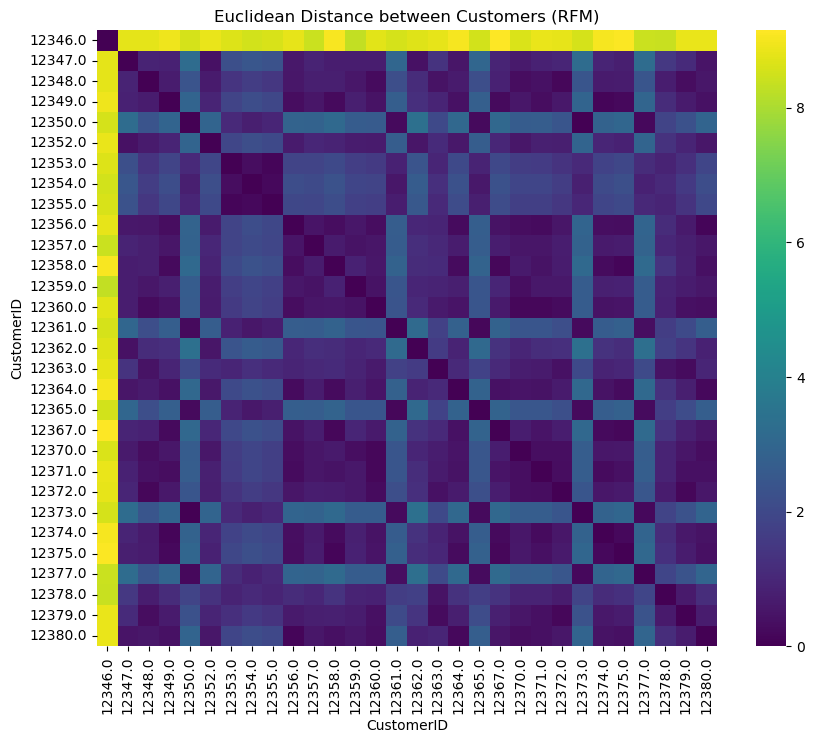

In [11]:
from scipy.spatial.distance import pdist, squareform
import seaborn as sns
import matplotlib.pyplot as plt

# Normalize RFM values
rfm_scaled = rfm[['Recency', 'Frequency', 'Monetary']]
rfm_scaled = (rfm_scaled - rfm_scaled.mean()) / rfm_scaled.std()

# Euclidean distance
euclidean_dist = pd.DataFrame(
    squareform(pdist(rfm_scaled, metric='euclidean')),
    index=rfm['CustomerID'],
    columns=rfm['CustomerID']
)

# Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(euclidean_dist.iloc[:30, :30], cmap='viridis')  # visualize a subset for clarity
plt.title("Euclidean Distance between Customers (RFM)")
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Get top 10 StockCodes per customer
top10_dict = df.groupby('CustomerID')['StockCode'].apply(
    lambda x: x.value_counts().nlargest(10).index.tolist()
)

# Step 2: Convert to sets for Jaccard calculation
top10_sets = top10_dict.apply(set)

# Step 3: Prepare customer index
customer_ids = top10_sets.index
jaccard_sim = pd.DataFrame(index=customer_ids, columns=customer_ids)

# Step 4: Compute Jaccard similarity
for i in customer_ids:
    for j in customer_ids:
        if pd.isna(jaccard_sim.loc[i, j]):  # Avoid recomputation
            intersection = len(top10_sets[i].intersection(top10_sets[j]))
            union = len(top10_sets[i].union(top10_sets[j]))
            score = intersection / union if union > 0 else 0
            jaccard_sim.loc[i, j] = score
            jaccard_sim.loc[j, i] = score  # Symmetric

# Step 5: Convert to float for heatmap
jaccard_sim = jaccard_sim.astype(float)

# Step 6: Visualize subset (e.g., first 30 customers)
plt.figure(figsize=(12, 10))
sns.heatmap(jaccard_sim.iloc[:30, :30], cmap='YlGnBu', annot=False)
plt.title("Jaccard Similarity on Top 10 Purchased StockCodes (First 30 Customers)")
plt.tight_layout()
plt.show()


In [11]:
from sklearn.preprocessing import StandardScaler

# Scale the RFM features
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

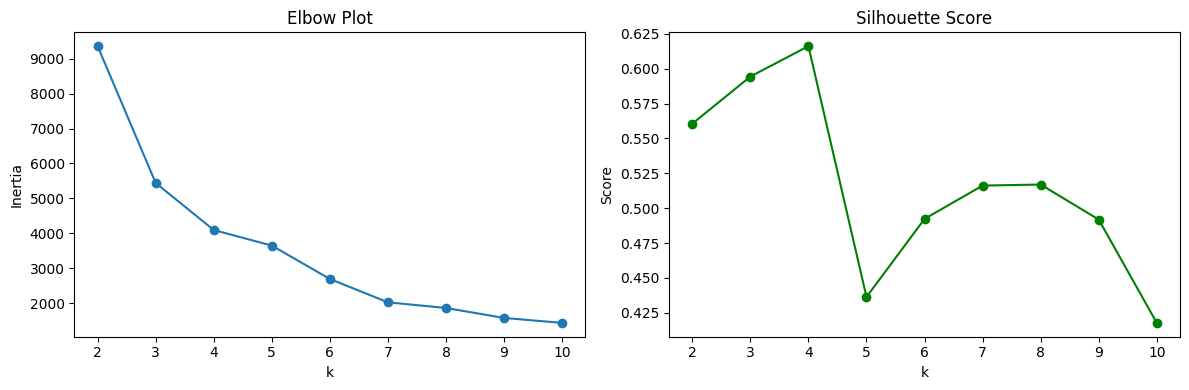

In [12]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

inertia = []
silhouette = []

K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(rfm_scaled)
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(rfm_scaled, labels))

# Plot Elbow and Silhouette
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(K_range, inertia, marker='o')
ax[0].set_title("Elbow Plot")
ax[0].set_xlabel("k")
ax[0].set_ylabel("Inertia")

ax[1].plot(K_range, silhouette, marker='o', color='green')
ax[1].set_title("Silhouette Score")
ax[1].set_xlabel("k")
ax[1].set_ylabel("Score")

plt.tight_layout()
plt.show()


In [13]:
kmeans = KMeans(n_clusters=3, random_state=42)
rfm['KMeans_Cluster'] = kmeans.fit_predict(rfm_scaled)


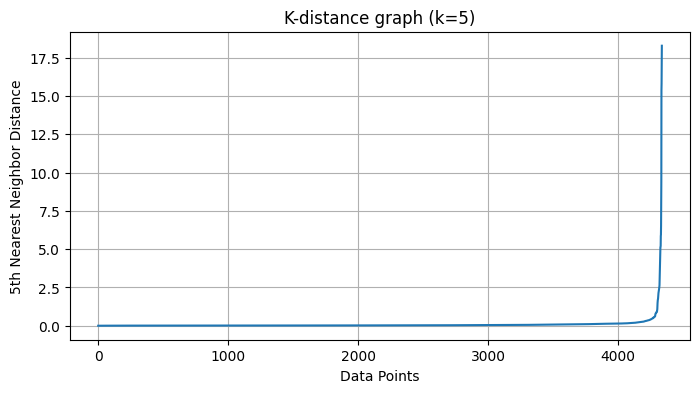

In [14]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
import numpy as np

# Determine good eps using k-distance graph
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(rfm_scaled)
distances, _ = neighbors_fit.kneighbors(rfm_scaled)
distances = np.sort(distances[:, 4])

plt.figure(figsize=(8, 4))
plt.plot(distances)
plt.title("K-distance graph (k=5)")
plt.xlabel("Data Points")
plt.ylabel("5th Nearest Neighbor Distance")
plt.grid()
plt.show()


In [15]:
dbscan = DBSCAN(eps=1.2, min_samples=5)  # adjust eps as per curve
rfm['DBSCAN_Cluster'] = dbscan.fit_predict(rfm_scaled)


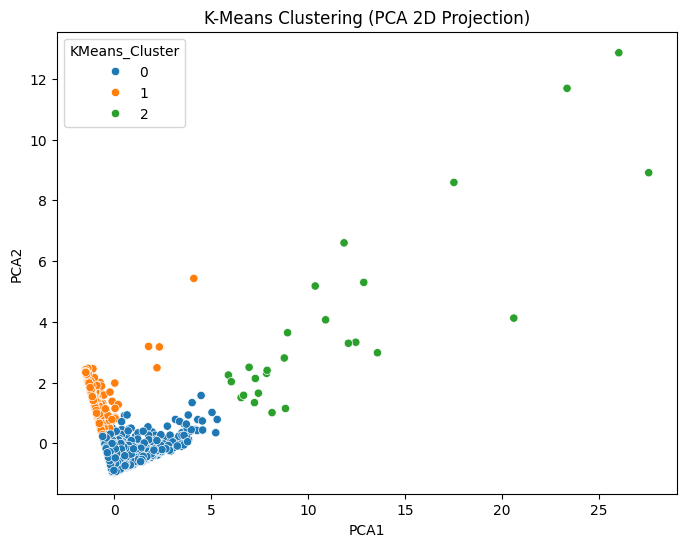

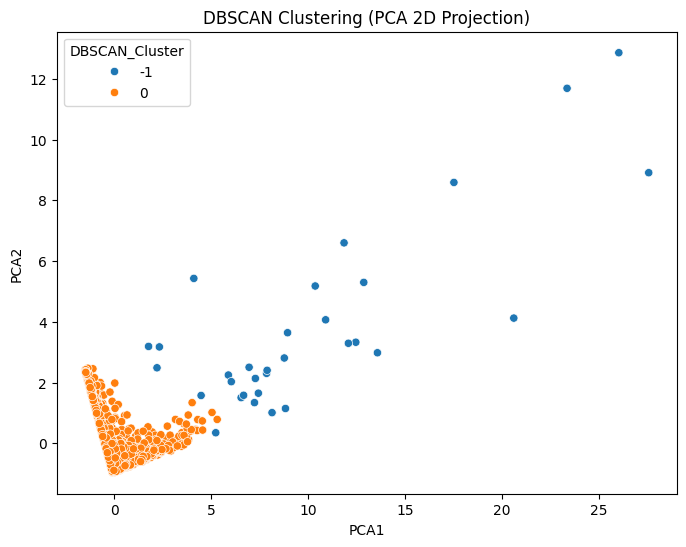

In [16]:
from sklearn.decomposition import PCA
import seaborn as sns

# Reduce to 2D
pca = PCA(n_components=2)
rfm_pca = pca.fit_transform(rfm_scaled)
rfm['PCA1'] = rfm_pca[:, 0]
rfm['PCA2'] = rfm_pca[:, 1]

# KMeans plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=rfm, x='PCA1', y='PCA2', hue='KMeans_Cluster', palette='tab10')
plt.title("K-Means Clustering (PCA 2D Projection)")
plt.show()

# DBSCAN plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=rfm, x='PCA1', y='PCA2', hue='DBSCAN_Cluster', palette='tab10')
plt.title("DBSCAN Clustering (PCA 2D Projection)")
plt.show()


In [17]:
# Filter positive quantity
basket = df[df['Quantity'] > 0]

# Group by InvoiceNo and Description
basket = (basket
          .groupby(['InvoiceNo', 'Description'])['Quantity']
          .sum().unstack().fillna(0))

# Encode quantities into 0 (not purchased) / 1 (purchased)
basket = basket.applymap(lambda x: 1 if x > 0 else 0)
basket.head()


C:\Users\asim.jamil\AppData\Local\Temp\ipykernel_8028\759784242.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  basket = basket.applymap(lambda x: 1 if x > 0 else 0)


Description,4 PURPLE FLOCK DINNER CANDLES,50'S CHRISTMAS GIFT BAG LARGE,DOLLY GIRL BEAKER,I LOVE LONDON MINI BACKPACK,I LOVE LONDON MINI RUCKSACK,NINE DRAWER OFFICE TIDY,OVAL WALL MIRROR DIAMANTE,RED SPOT GIFT BAG LARGE,SET 2 TEA TOWELS I LOVE LONDON,SPACEBOY BABY GIFT SET,...,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536365,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536366,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536367,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536368,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536369,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
from mlxtend.frequent_patterns import apriori, association_rules
import time

# Start timer
start_apriori = time.time()

# Apply Apriori with min_support = 0.02
frequent_items_apriori = apriori(basket, min_support=0.02, use_colnames=True)

# Generate association rules
rules_apriori = association_rules(frequent_items_apriori, metric="confidence", min_threshold=0.6)

# Filter rules
rules_apriori = rules_apriori[(rules_apriori['confidence'] >= 0.6) & (rules_apriori['lift'] >= 1.2)]

# End timer
end_apriori = time.time()
apriori_time = end_apriori - start_apriori

# Top 10 by lift
rules_apriori_top10 = rules_apriori.sort_values('lift', ascending=False).head(10)
rules_apriori_top10


C:\Users\asim.jamil\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
19,(PINK REGENCY TEACUP AND SAUCER),"(GREEN REGENCY TEACUP AND SAUCER, ROSES REGENC...",0.029996,0.029186,0.021040,0.701439,24.033032,1.0,0.020165,3.251641,0.988027,0.551627,0.692463,0.711163
17,"(GREEN REGENCY TEACUP AND SAUCER, ROSES REGENC...",(PINK REGENCY TEACUP AND SAUCER),0.029186,0.029996,0.021040,0.720887,24.033032,1.0,0.020165,3.475313,0.987204,0.551627,0.712256,0.711163
18,"(PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY...",(GREEN REGENCY TEACUP AND SAUCER),0.023522,0.037279,0.021040,0.894495,23.994742,1.0,0.020163,9.124923,0.981409,0.529172,0.890410,0.729447
8,(PINK REGENCY TEACUP AND SAUCER),(GREEN REGENCY TEACUP AND SAUCER),0.029996,0.037279,0.024817,0.827338,22.193256,1.0,0.023698,5.575760,0.984471,0.584498,0.820652,0.746520
7,(GREEN REGENCY TEACUP AND SAUCER),(PINK REGENCY TEACUP AND SAUCER),0.037279,0.029996,0.024817,0.665702,22.193256,1.0,0.023698,2.901615,0.991919,0.584498,0.655364,0.746520
16,"(GREEN REGENCY TEACUP AND SAUCER, PINK REGENCY...",(ROSES REGENCY TEACUP AND SAUCER ),0.024817,0.042242,0.021040,0.847826,20.070631,1.0,0.019992,6.293837,0.974356,0.457210,0.841114,0.672955
14,(PINK REGENCY TEACUP AND SAUCER),(ROSES REGENCY TEACUP AND SAUCER ),0.029996,0.042242,0.023522,0.784173,18.563760,1.0,0.022255,4.437611,0.975389,0.482835,0.774654,0.670503
9,(GREEN REGENCY TEACUP AND SAUCER),(ROSES REGENCY TEACUP AND SAUCER ),0.037279,0.042242,0.029186,0.782923,18.534184,1.0,0.027612,4.412071,0.982679,0.579850,0.773349,0.736928
10,(ROSES REGENCY TEACUP AND SAUCER ),(GREEN REGENCY TEACUP AND SAUCER),0.042242,0.037279,0.029186,0.690932,18.534184,1.0,0.027612,3.114920,0.987771,0.579850,0.678964,0.736928
4,(DOLLY GIRL LUNCH BOX),(SPACEBOY LUNCH BOX ),0.033233,0.037980,0.022874,0.688312,18.122934,1.0,0.021612,3.086480,0.977300,0.473214,0.676006,0.645292


In [19]:
from mlxtend.frequent_patterns import fpgrowth

# Start timer
start_fpgrowth = time.time()

# Apply FP-Growth
frequent_items_fpgrowth = fpgrowth(basket, min_support=0.02, use_colnames=True)

# Generate rules
rules_fpgrowth = association_rules(frequent_items_fpgrowth, metric="confidence", min_threshold=0.6)

# Filter rules
rules_fpgrowth = rules_fpgrowth[(rules_fpgrowth['confidence'] >= 0.6) & (rules_fpgrowth['lift'] >= 1.2)]

# End timer
end_fpgrowth = time.time()
fpgrowth_time = end_fpgrowth - start_fpgrowth

# Top 10 by lift
rules_fpgrowth_top10 = rules_fpgrowth.sort_values('lift', ascending=False).head(10)
rules_fpgrowth_top10


C:\Users\asim.jamil\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
17,(PINK REGENCY TEACUP AND SAUCER),"(GREEN REGENCY TEACUP AND SAUCER, ROSES REGENC...",0.029996,0.029186,0.021040,0.701439,24.033032,1.0,0.020165,3.251641,0.988027,0.551627,0.692463,0.711163
15,"(GREEN REGENCY TEACUP AND SAUCER, ROSES REGENC...",(PINK REGENCY TEACUP AND SAUCER),0.029186,0.029996,0.021040,0.720887,24.033032,1.0,0.020165,3.475313,0.987204,0.551627,0.712256,0.711163
16,"(PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY...",(GREEN REGENCY TEACUP AND SAUCER),0.023522,0.037279,0.021040,0.894495,23.994742,1.0,0.020163,9.124923,0.981409,0.529172,0.890410,0.729447
12,(PINK REGENCY TEACUP AND SAUCER),(GREEN REGENCY TEACUP AND SAUCER),0.029996,0.037279,0.024817,0.827338,22.193256,1.0,0.023698,5.575760,0.984471,0.584498,0.820652,0.746520
11,(GREEN REGENCY TEACUP AND SAUCER),(PINK REGENCY TEACUP AND SAUCER),0.037279,0.029996,0.024817,0.665702,22.193256,1.0,0.023698,2.901615,0.991919,0.584498,0.655364,0.746520
14,"(GREEN REGENCY TEACUP AND SAUCER, PINK REGENCY...",(ROSES REGENCY TEACUP AND SAUCER ),0.024817,0.042242,0.021040,0.847826,20.070631,1.0,0.019992,6.293837,0.974356,0.457210,0.841114,0.672955
13,(PINK REGENCY TEACUP AND SAUCER),(ROSES REGENCY TEACUP AND SAUCER ),0.029996,0.042242,0.023522,0.784173,18.563760,1.0,0.022255,4.437611,0.975389,0.482835,0.774654,0.670503
10,(ROSES REGENCY TEACUP AND SAUCER ),(GREEN REGENCY TEACUP AND SAUCER),0.042242,0.037279,0.029186,0.690932,18.534184,1.0,0.027612,3.114920,0.987771,0.579850,0.678964,0.736928
9,(GREEN REGENCY TEACUP AND SAUCER),(ROSES REGENCY TEACUP AND SAUCER ),0.037279,0.042242,0.029186,0.782923,18.534184,1.0,0.027612,4.412071,0.982679,0.579850,0.773349,0.736928
7,(SPACEBOY LUNCH BOX ),(DOLLY GIRL LUNCH BOX),0.037980,0.033233,0.022874,0.602273,18.122934,1.0,0.021612,2.430729,0.982122,0.473214,0.588601,0.645292


In [20]:
print(f"Apriori runtime: {apriori_time:.2f} seconds")
print(f"FP-Growth runtime: {fpgrowth_time:.2f} seconds")


Apriori runtime: 8.57 seconds
FP-Growth runtime: 9.43 seconds


In [21]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Binarizer
import numpy as np

# Label customers as High Value if Monetary > 75th percentile
threshold = rfm['Monetary'].quantile(0.75)
rfm['HighValue'] = (rfm['Monetary'] > threshold).astype(int)

# Features for GaussianNB
X_rfm = rfm[['Recency', 'Frequency', 'Monetary']]
y_rfm = rfm['HighValue']

# Train-test split
X_train_rfm, X_test_rfm, y_train_rfm, y_test_rfm = train_test_split(X_rfm, y_rfm, test_size=0.2, random_state=42)


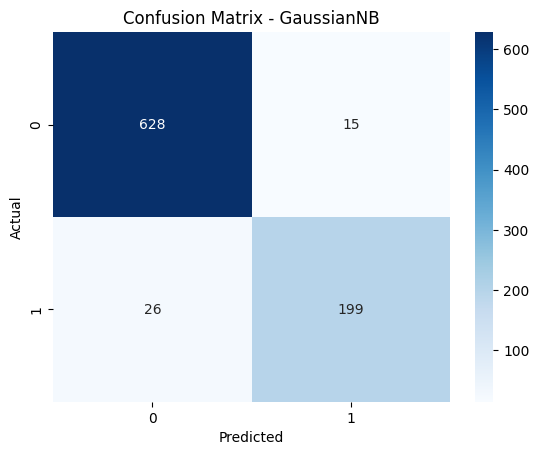

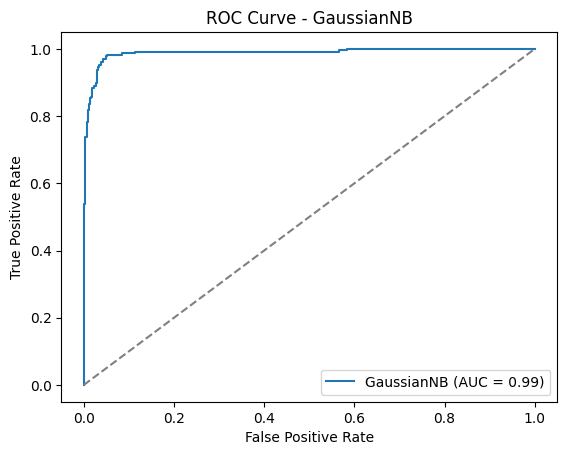

In [22]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Train model
gnb = GaussianNB()
gnb.fit(X_train_rfm, y_train_rfm)

# Predict
y_pred_gnb = gnb.predict(X_test_rfm)
y_proba_gnb = gnb.predict_proba(X_test_rfm)[:, 1]

# Confusion Matrix
cm_gnb = confusion_matrix(y_test_rfm, y_pred_gnb)
sns.heatmap(cm_gnb, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - GaussianNB")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve
fpr_gnb, tpr_gnb, _ = roc_curve(y_test_rfm, y_proba_gnb)
roc_auc_gnb = auc(fpr_gnb, tpr_gnb)
plt.plot(fpr_gnb, tpr_gnb, label=f'GaussianNB (AUC = {roc_auc_gnb:.2f})')
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - GaussianNB')
plt.legend()
plt.show()


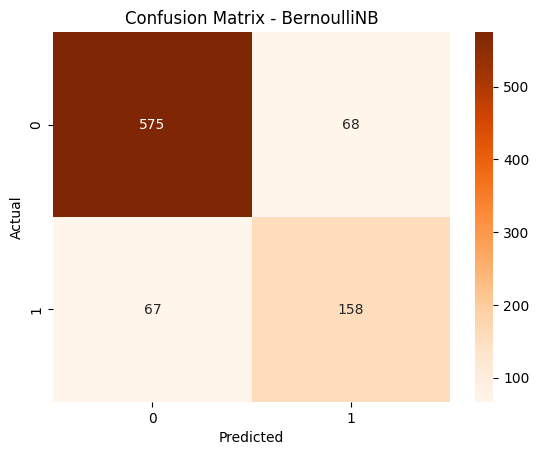

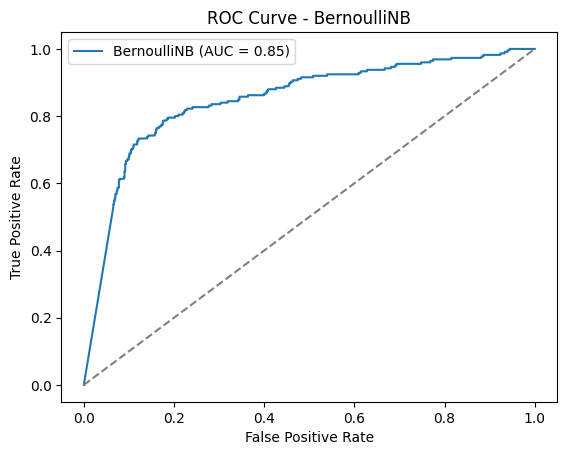

In [23]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

# --- Ensure CustomerID is set as index in RFM ---
rfm = rfm.set_index('CustomerID')  # Make sure rfm index is CustomerID

# --- Map Invoices to CustomerID ---
# Build invoice-to-customer map from original dataset
invoice_to_customer = df.drop_duplicates(subset='InvoiceNo')[['InvoiceNo', 'CustomerID']]\
                         .set_index('InvoiceNo')['CustomerID'].to_dict()

# --- Use basket data from association rule step ---
basket_binarized = basket.copy()
basket_binarized['CustomerID'] = basket_binarized.index.map(invoice_to_customer)

# Drop any rows where mapping failed
basket_binarized.dropna(subset=['CustomerID'], inplace=True)

# Convert CustomerID to integer (if needed)
basket_binarized['CustomerID'] = basket_binarized['CustomerID'].astype(int)

# Group by CustomerID to get binary matrix
basket_binary = basket_binarized.groupby('CustomerID').max()

# Align with RFM customers
basket_binary = basket_binary.loc[basket_binary.index.intersection(rfm.index)]
y_binary = rfm.loc[basket_binary.index, 'HighValue']

# --- Train/Test Split ---
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(
    basket_binary, y_binary, test_size=0.2, random_state=42
)

# --- Train BernoulliNB ---
bnb = BernoulliNB()
bnb.fit(X_train_b, y_train_b)

# --- Predict ---
y_pred_bnb = bnb.predict(X_test_b)
y_proba_bnb = bnb.predict_proba(X_test_b)[:, 1]

# --- Confusion Matrix ---
cm_bnb = confusion_matrix(y_test_b, y_pred_bnb)
sns.heatmap(cm_bnb, annot=True, fmt='d', cmap='Oranges')
plt.title("Confusion Matrix - BernoulliNB")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# --- ROC Curve ---
fpr_bnb, tpr_bnb, _ = roc_curve(y_test_b, y_proba_bnb)
roc_auc_bnb = auc(fpr_bnb, tpr_bnb)

plt.plot(fpr_bnb, tpr_bnb, label=f'BernoulliNB (AUC = {roc_auc_bnb:.2f})')
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - BernoulliNB')
plt.legend()
plt.show()


In [24]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Target: High Value (Monetary > 75th percentile)
rfm['HighValue'] = (rfm['Monetary'] > rfm['Monetary'].quantile(0.75)).astype(int)

X = rfm[['Recency', 'Frequency', 'Monetary']]
y = rfm['HighValue']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [25]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Grid search parameters
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 0.01, 0.1, 1]
}

# Linear Kernel
svc_linear = GridSearchCV(SVC(kernel='linear'), param_grid={'C': [0.1, 1, 10]}, cv=5)
svc_linear.fit(X_train, y_train)
linear_best = svc_linear.best_estimator_

# RBF Kernel
svc_rbf = GridSearchCV(SVC(kernel='rbf'), param_grid=param_grid, cv=5)
svc_rbf.fit(X_train, y_train)
rbf_best = svc_rbf.best_estimator_

# Test accuracies
acc_linear = accuracy_score(y_test, linear_best.predict(X_test))
acc_rbf = accuracy_score(y_test, rbf_best.predict(X_test))


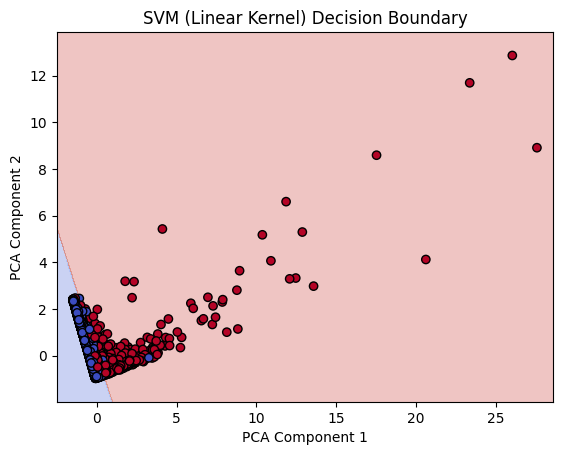

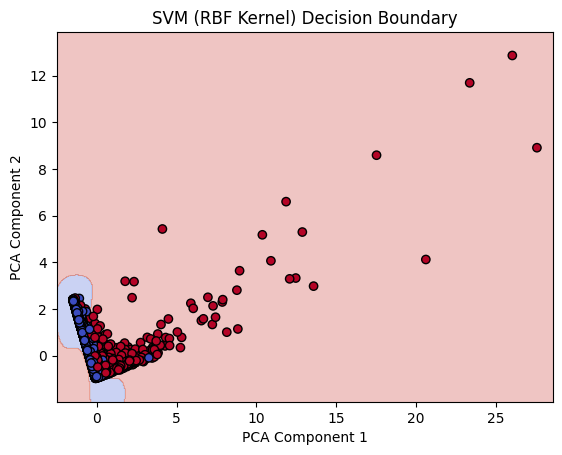

In [26]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
X_train_pca, X_test_pca = train_test_split(X_pca, test_size=0.2, random_state=42)

# Refit models on PCA-transformed data
svc_linear_pca = SVC(kernel='linear', C=svc_linear.best_params_['C']).fit(X_train_pca, y_train)
svc_rbf_pca = SVC(kernel='rbf', C=svc_rbf.best_params_['C'], gamma=svc_rbf.best_params_['gamma']).fit(X_train_pca, y_train)

# Plotting function
def plot_decision_boundary(model, X, y, title):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                         np.linspace(y_min, y_max, 500))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, cmap='coolwarm', alpha=0.3)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', edgecolors='k')
    plt.title(title)
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.show()

plot_decision_boundary(svc_linear_pca, X_pca, y, "SVM (Linear Kernel) Decision Boundary")
plot_decision_boundary(svc_rbf_pca, X_pca, y, "SVM (RBF Kernel) Decision Boundary")


In [27]:
import pandas as pd

summary_df = pd.DataFrame({
    'Model': ['SVM Linear', 'SVM RBF'],
    'Best C': [svc_linear.best_params_['C'], svc_rbf.best_params_['C']],
    'Best Gamma': ['N/A', svc_rbf.best_params_['gamma']],
    'Test Accuracy': [acc_linear, acc_rbf]
})

summary_df


,Model,Best C,Best Gamma,Test Accuracy
0,SVM Linear,10,N/A,0.996544
1,SVM RBF,10,1,0.991935


In [28]:
from sklearn.metrics import classification_report

y_pred = svc_linear.predict(X_test)
print("SVM Linear Classification Report:")
print(classification_report(y_test, y_pred))

SVM Linear Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       643
           1       1.00      0.99      0.99       225

    accuracy                           1.00       868
   macro avg       1.00      0.99      1.00       868
weighted avg       1.00      1.00      1.00       868



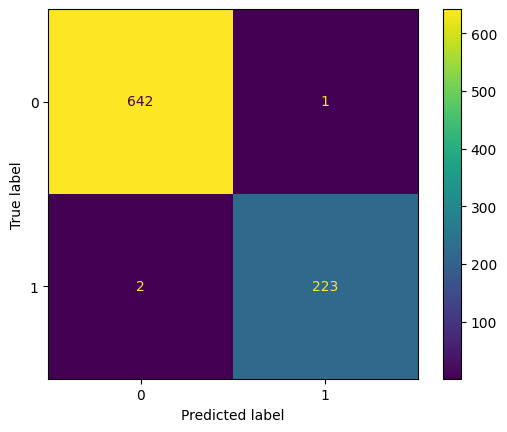

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()


In [30]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(svc_linear, X, y, cv=5, scoring='accuracy')
print("Cross-validation accuracy scores:", scores)
print("Mean CV accuracy:", scores.mean())

Cross-validation accuracy scores: [0.99654378 1.         0.99769585 1.         1.        ]
Mean CV accuracy: 0.9988479262672811
